<img src="https://s3.amazonaws.com/datascienceheroes.com/EDV/360_banner_python.png" width="400px">


# Escuela de Datos Vivos 

## LAB P.G.1.6: Outliers en variables numéricas
Creado por Pablo Casas | https://escueladedatosvivos.ai    

Resuelto por Pablo Sotomayor

---

## Ejercicios

1) Cargar los datos de `german_credit_data_ex.csv`:

2) Crear un decision tree prediciendo la variable `Risk` (binaria)

Excluir variable `Duration`.

3) Ahora hacer un random forest

4) Comparar las métricas de error (área bajo la curva ROC)

5) Sacar outliers con winsorize, analizar que variables son plausibles para ello.

6) Repetir (correr el proceso del pto 2 y 3 de nuevo), y comparar.

7) ¿Cambiaron las métricas? ¿Cuál es el impacto de outliers en un caso y en otro?

Nota: Las comparaciones son:

a) Decision tree vs random forest
b) Con los datos preparados por winsorize: Decision tree vs. random forest



## Solución

In [62]:
# Librerías que vamos a utilizar

import pydotplus
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from funpymodeling.exploratory import freq_tbl, status, profiling_num, cat_vars, num_vars
from IPython.display import Image  
from scipy.stats.mstats import winsorize
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.tree import export_graphviz
from yellowbrick.classifier.threshold import discrimination_threshold
from yellowbrick.regressor import ResidualsPlot

warnings.filterwarnings('ignore')
%matplotlib inline

1) Carga de datos

In [63]:
data = pd.read_csv("../data/german_credit_data_ex.csv", sep = ",")
data_original = data.copy()

print(f"Cantidad de registros: {data.shape[0]}")
print(f"Cantidad de variables: {data.shape[1]}")

Cantidad de registros: 1000
Cantidad de variables: 10


Inspeccionamos los datos elegiendo una muestra al azar

In [64]:
data.head()

,Age,Sex,Job,Housing,Saving_accounts,Checking_account,Credit_amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169.000000,6,radio/TV,good
1,85,female,2,own,19249.170894091894,moderate,30042.882007,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096.000000,12,education,good
3,85,male,2,free,19565.146628748196,little,36924.074661,42,furniture/equipment,good
4,85,male,2,free,18835.73815632353,little,35475.970467,24,car,bad


Revisamos el estado de los datos

In [65]:
print(f"Cantidad de variables numéricas: {len(num_vars(data))}")
print(f"Cantidad de variables: {len(cat_vars(data))}")
status(data).sort_values(by=["p_nan", "p_zeros", "unique"], ascending=False)

Cantidad de variables numéricas: 4
Cantidad de variables: 6


,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
5,Checking_account,394,0.394,0,0.000,3,object
4,Saving_accounts,182,0.182,0,0.000,25,object
2,Job,0,0.000,22,0.022,4,int64
6,Credit_amount,0,0.000,0,0.000,925,float64
0,Age,0,0.000,0,0.000,54,int64
7,Duration,0,0.000,0,0.000,33,int64
8,Purpose,0,0.000,0,0.000,8,object
3,Housing,0,0.000,0,0.000,3,object
1,Sex,0,0.000,0,0.000,2,object
9,Risk,0,0.000,0,0.000,2,object


Tenemos 4 variables declaradas como numéricas y 6 declaradas como categóricas. Las variables categóricas "Checking_account" y "Saving_accounts" tienen valores nulos (39.4% y 18.2% del total, respectivamente). La variable numérica "Job" tiene 4 valores ceros. La variable "Job" está mal declarada, debe ser categórica. La variable "Saving_accounts" además parece estar mal proporcionada para el análisis.

Transformamos la variable "Job"

In [66]:
data["Job_cat"] = data["Job"].astype("str")

In [67]:
status(data[["Job", "Job_cat"]])

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,Job,0,0.0,22,0.022,4,int64
1,Job_cat,0,0.0,0,0.000,4,object


Eliminamos la variable "Job" mal declarada

In [68]:
data = data.drop("Job", axis=1)

In [69]:
data["Job_cat"].value_counts()

2    630
1    200
3    148
0     22
Name: Job_cat, dtype: int64

Analizamos la variable "Saving_accounts"

In [70]:
data["Saving_accounts"].value_counts()

little                588
moderate              101
quite rich             61
rich                   47
18944.058501159107      1
18408.431922106345      1
22979.33097282893       1
17237.59394059629       1
19161.819608091035      1
26444.294209840747      1
19249.170894091894      1
14109.025841428076      1
18835.73815632353       1
19963.854984782258      1
23554.45336175181       1
16358.047315098602      1
23999.04866877007       1
13691.526199378803      1
19565.146628748196      1
21220.436727642402      1
19355.468177681556      1
19693.267963723298      1
13112.976739759817      1
18774.8964749413        1
21653.19241673529       1
Name: Saving_accounts, dtype: int64

Nos quedaremos únicamente con los registros que tienen los valores "little", "moderate", "quite rich", y "rich". También con los valores nulos.

In [71]:
mask = (data["Saving_accounts"] == "little") | (data["Saving_accounts"] == "moderate") | \
    (data["Saving_accounts"] == "quite rich") | (data["Saving_accounts"] == "rich") | (data["Saving_accounts"].isnull())
data[mask]["Saving_accounts"].value_counts()

little        588
moderate      101
quite rich     61
rich           47
Name: Saving_accounts, dtype: int64

In [72]:
data = data[mask]

Vemos que ahora la variable "Saving_acoounts" únicamente toma los 4 valores pedidos y el NaN.

In [73]:
data["Saving_accounts"]

0           NaN
2        little
8          rich
9        little
10       little
         ...   
995      little
996      little
997      little
998      little
999    moderate
Name: Saving_accounts, Length: 979, dtype: object

Para las variables categóricas 'Saving_accounts' y 'Checking_account' asignamos los valores nulos en una clase "nulo"

In [74]:
vars_to_fill_nan = cat_vars(data)

In [75]:
data[vars_to_fill_nan] = data[vars_to_fill_nan].fillna(value="nulo")

In [76]:
status(data[vars_to_fill_nan])

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,Sex,0,0.0,0,0.0,2,object
1,Housing,0,0.0,0,0.0,3,object
2,Saving_accounts,0,0.0,0,0.0,5,object
3,Checking_account,0,0.0,0,0.0,4,object
4,Purpose,0,0.0,0,0.0,8,object
5,Risk,0,0.0,0,0.0,2,object
6,Job_cat,0,0.0,0,0.0,4,object


Pasamos todas las variables a numéricas con one-hot encoding

In [77]:
data = pd.get_dummies(data, drop_first=True)

In [78]:
status(data)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,Age,0,0.0,0,0.000000,54,int64
1,Credit_amount,0,0.0,0,0.000000,904,float64
2,Duration,0,0.0,0,0.000000,33,int64
3,Sex_male,0,0.0,305,0.311542,2,uint8
4,Housing_own,0,0.0,278,0.283963,2,uint8
5,Housing_rent,0,0.0,804,0.821246,2,uint8
6,Saving_accounts_moderate,0,0.0,878,0.896834,2,uint8
7,Saving_accounts_nulo,0,0.0,797,0.814096,2,uint8
8,Saving_accounts_quite rich,0,0.0,918,0.937692,2,uint8
9,Saving_accounts_rich,0,0.0,932,0.951992,2,uint8


2) Creamos un árbol de clasificación binaria para la variable "Risk"

Dividimos en TR/TS

In [79]:
data_x = data.drop('Risk_good', axis=1)
data_y = data['Risk_good']

x_tr, x_ts, y_tr, y_ts = train_test_split(data_x, 
                                          data_y, 
                                          test_size=0.2, 
                                          random_state=0)

Creamos el modelo de árbol de decisión

In [19]:
model = tree.DecisionTreeClassifier(max_depth=3,
                                    max_features=10,
                                    min_samples_split=50,
                                    min_samples_leaf=30,
                                    random_state=1)

Entrenamos el modelo

In [20]:
model.fit(x_tr, y_tr)

DecisionTreeClassifier(max_depth=3, max_features=10, min_samples_leaf=30,
                       min_samples_split=50, random_state=1)

Visualizamos el modelo

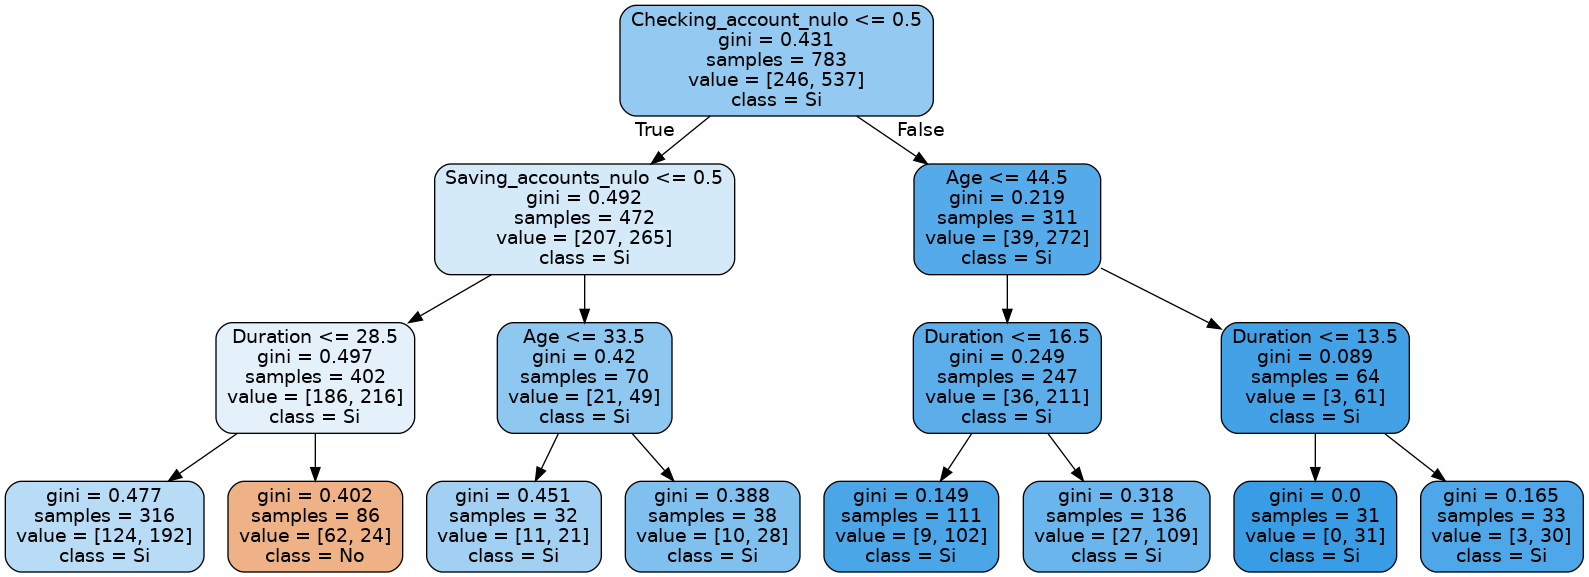

In [21]:
dot_data = tree.export_graphviz(model, 
                                out_file=None, 
                                feature_names=list(x_tr.columns.values), 
                                class_names=['No', 'Si'], 
                                rounded=True, 
                                filled=True)

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

Predicción de la clase

In [22]:
pred_probs = model.predict_proba(x_tr)

In [23]:
y_prob_tr = pred_probs[:,1]

Matriz de confusión

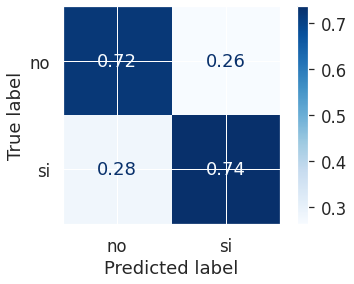

In [24]:
# Normalizado por filas
sns.set(font_scale=1.5)
plot_confusion_matrix(model, x_tr, y_tr,
                      display_labels=['no','si'],
                      cmap='Blues',
                      normalize='pred'
                     )

Curva ROC

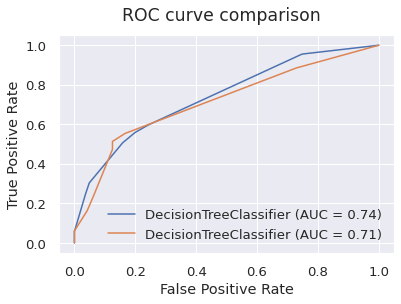

In [25]:
sns.set(font_scale=1.2)
tr_disp = plot_roc_curve(model, x_tr, y_tr)
ts_disp = plot_roc_curve(model, x_ts, y_ts, ax=tr_disp.ax_)
ts_disp.figure_.suptitle("ROC curve comparison")

plt.show()

3) Implementación de un modelo RandomForest para clasificación

In [26]:
rf = RandomForestClassifier(n_estimators=10,
                            min_samples_split=50,   
                            min_samples_leaf=30,
                            random_state = 1)

Entrenamos al modelo

In [27]:
rf.fit(x_tr, y_tr)

RandomForestClassifier(min_samples_leaf=30, min_samples_split=50,
                       n_estimators=10, random_state=1)

Matriz de confusión

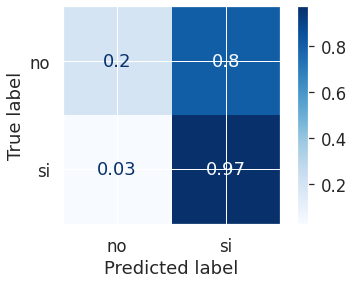

In [28]:
sns.set(font_scale=1.5) #  Ajuste tamaño de letra (var global)

plot_confusion_matrix(rf, x_tr, y_tr,
                      display_labels=['no','si'],
                      cmap='Blues',
                      normalize='true'
                     )

Revisamos el valor del punto de corte para la clasificación de los datos

In [29]:
y_prob_tr=pred_probs[:,1]

In [30]:
pred_probs=rf.predict_proba(x_tr)

In [31]:
print(f"Valor medio de las probabilidades predichas para el conjunto de entrenamiento = {y_prob_tr.mean()}")

Valor medio de las probabilidades predichas para el conjunto de entrenamiento = 0.685823754789272


In [32]:
y_pred_tr_2 = np.where(y_prob_tr>y_prob_tr.mean(), 1, 0)

Determinamos la matriz de confusión con el nuevo punto de corte

Matriz normalizada por los valores verdaderos:

In [33]:
conf_mat_2 = pd.crosstab(
    index=y_tr,
    columns=y_pred_tr_2,
    rownames=['Actual'],
    colnames=['Pred'],
    normalize="index")
conf_mat_2

Pred,0,1
Actual,,
0,0.800813,0.199187
1,0.441341,0.558659


Matriz normalizada por las predicciones del modelo:

In [34]:
conf_mat_2 = pd.crosstab(
    index=y_tr,
    columns=y_pred_tr_2,
    rownames=['Actual'],
    colnames=['Pred'],
    normalize="columns")
conf_mat_2

Pred,0,1
Actual,,
0,0.453917,0.140401
1,0.546083,0.859599


Vemos que con el nuevo punto de corte en la matriz normalizada por valores verdaderos de los datos:

- El 82% de casos falsos son predichos correctamente por el modelo.
- El 62% de casos verdaderos son predichos correctamente por el modelo.

Para la matriz normalizada por valores que el modelo predice para los datos:

- El 88% de casos que el modelo etiqueta como positivos están bien predichos.
- El 50% de casos que el modelo predice como falsos en realidad son verdaderos.

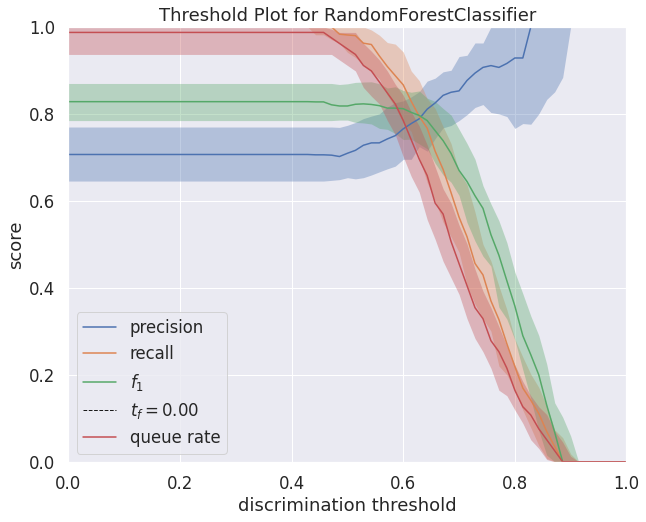

In [35]:
plt.figure(figsize=(10,8))
dis_res=discrimination_threshold(rf, x_tr, y_tr)
plt.show()

Vemos que el umbral según discrimination_threshold es el 0.0 (lo cual no puede ser)

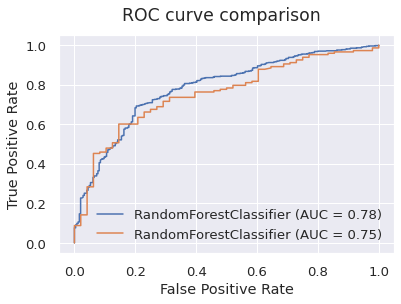

In [36]:
sns.set(font_scale=1.2)
tr_disp = plot_roc_curve(rf, x_tr, y_tr)
ts_disp = plot_roc_curve(rf, x_ts, y_ts, ax=tr_disp.ax_)
ts_disp.figure_.suptitle("ROC curve comparison")

plt.show()

5) Tratamiento de outliers con winsorize

In [85]:
profiling_num(data_x).sort_values('variation_coef', ascending=False)

,variable,mean,std_dev,variation_coef,p_0.01,p_0.05,p_0.25,p_0.5,p_0.75,p_0.95,p_0.99
1,Credit_amount,3433.684797,3520.198141,1.025195,422.26,708.9,1364.0,2323.0,3974.5,9577.7,15712.7
2,Duration,20.846782,12.014179,0.576309,6.00,6.0,12.0,18.0,24.0,48.0,60.0
0,Age,35.867211,12.016550,0.335029,20.00,22.0,27.0,33.0,42.0,61.0,74.0


In [86]:
data[num_vars(data_x)].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,979.0,35.867211,12.016550,19.0,27.0,33.0,42.0,85.000000
Credit_amount,979.0,3433.684797,3520.198141,250.0,1364.0,2323.0,3974.5,31825.398986
Duration,979.0,20.846782,12.014179,4.0,12.0,18.0,24.0,72.000000


Seleccionamos las columnas a las que le aplicaremos el método Winsorize

In [87]:
cols_to_stop = ['Credit_amount', 'Duration', 'Age']

Hacemos una copia para no perder los datos trabajados

In [88]:
data_x_2 = data_x.copy()

Aplicamos la transformación y consideramos el límite superior como el cuantil 0.97

In [89]:
for col in cols_to_stop: 
     data_x_2[col] = winsorize(data_x_2[col], limits=[None, 0.03])

Como el problema es de clasificación no aplicamos el método a la variable a predecir

In [90]:
profiling_num(data_x_2).sort_values('variation_coef', ascending=False)

,variable,mean,std_dev,variation_coef,p_0.01,p_0.05,p_0.25,p_0.5,p_0.75,p_0.95,p_0.99
1,Credit_amount,3267.622063,2721.577633,0.832892,422.26,708.9,1364.0,2323.0,3974.5,9577.7,11816.0
2,Duration,20.650664,11.448316,0.554380,6.00,6.0,12.0,18.0,24.0,48.0,48.0
0,Age,35.612870,11.227626,0.315269,20.00,22.0,27.0,33.0,42.0,61.0,64.0


Definimos el modelo y entrenamos la nueva versión

In [91]:
x_tr_2, x_ts_2, y_tr_2, y_ts_2 = train_test_split(data_x_2, 
                                                  data_y, 
                                                  test_size=0.2, 
                                                  random_state=0)

Modelo de árbol de decisión

In [95]:
dt = tree.DecisionTreeClassifier(max_depth=3,
                                 max_features=10,
                                 min_samples_split=50,
                                 min_samples_leaf=30,
                                 random_state=1)

In [96]:
dt.fit(x_tr_2, y_tr_2)

DecisionTreeClassifier(max_depth=3, max_features=10, min_samples_leaf=30,
                       min_samples_split=50, random_state=1)

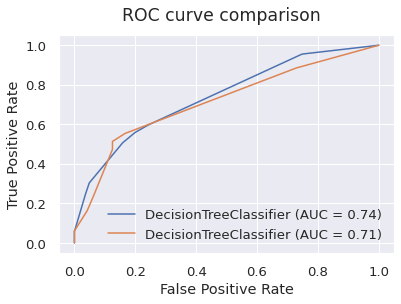

In [97]:
sns.set(font_scale=1.2)
tr_disp = plot_roc_curve(dt, x_tr_2, y_tr_2)
ts_disp = plot_roc_curve(dt, x_ts_2, y_ts_2, ax=tr_disp.ax_)
ts_disp.figure_.suptitle("ROC curve comparison")

plt.show()

No vemos cambios en el modelo al aplicar la ténica de Winsorize

Modelo RandomForest

In [92]:
rf = RandomForestClassifier(n_estimators=10,
                            min_samples_split=50,   
                            min_samples_leaf=30,
                            random_state = 1)

In [93]:
rf.fit(x_tr_2, y_tr_2)

RandomForestClassifier(min_samples_leaf=30, min_samples_split=50,
                       n_estimators=10, random_state=1)

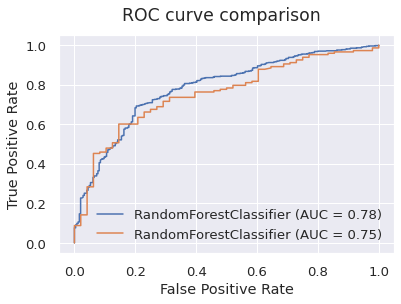

In [94]:
sns.set(font_scale=1.2)
tr_disp = plot_roc_curve(rf, x_tr_2, y_tr_2)
ts_disp = plot_roc_curve(rf, x_ts_2, y_ts_2, ax=tr_disp.ax_)
ts_disp.figure_.suptitle("ROC curve comparison")

plt.show()

No hay una mejora en el modelo.